In [142]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns
import utils
plt.style.use('ggplot')
pd.set_option('display.max_columns', 200)
pd.set_option('display.float_format', lambda x: '%.10f' % x)


In [143]:
df = pd.read_csv('suicide_ds_2016.csv')

In [144]:
df.info()
dir(utils)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27820 entries, 0 to 27819
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country             27820 non-null  object 
 1   year                27820 non-null  int64  
 2   sex                 27820 non-null  object 
 3   age                 27820 non-null  object 
 4   suicides_no         27820 non-null  int64  
 5   population          27820 non-null  int64  
 6   suicides/100k pop   27820 non-null  float64
 7   country-year        27820 non-null  object 
 8   HDI for year        8364 non-null   float64
 9    gdp_for_year ($)   27820 non-null  object 
 10  gdp_per_capita ($)  27820 non-null  int64  
 11  generation          27820 non-null  object 
dtypes: float64(2), int64(4), object(6)
memory usage: 2.5+ MB


['__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'clean_data',
 'np',
 'pd',
 'plt',
 'sns']

In [145]:
df.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.7100000000,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.1900000000,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.8300000000,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.5900000000,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.2800000000,Albania1987,NaN,"2,156,624,900",796,Boomers


In [146]:
df.tail()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
27815,Uzbekistan,2014,female,35-54 years,107,3620833,2.9600000000,Uzbekistan2014,0.6750000000,"63,067,077,179",2309,Generation X
27816,Uzbekistan,2014,female,75+ years,9,348465,2.5800000000,Uzbekistan2014,0.6750000000,"63,067,077,179",2309,Silent
27817,Uzbekistan,2014,male,5-14 years,60,2762158,2.1700000000,Uzbekistan2014,0.6750000000,"63,067,077,179",2309,Generation Z
27818,Uzbekistan,2014,female,5-14 years,44,2631600,1.6700000000,Uzbekistan2014,0.6750000000,"63,067,077,179",2309,Generation Z
27819,Uzbekistan,2014,female,55-74 years,21,1438935,1.4600000000,Uzbekistan2014,0.6750000000,"63,067,077,179",2309,Boomers


In [147]:
df.nunique()

country                 101
year                     32
sex                       2
age                       6
suicides_no            2084
population            25564
suicides/100k pop      5298
country-year           2321
HDI for year            305
 gdp_for_year ($)      2321
gdp_per_capita ($)     2233
generation                6
dtype: int64

In [148]:
df.isna().sum()

country                   0
year                      0
sex                       0
age                       0
suicides_no               0
population                0
suicides/100k pop         0
country-year              0
HDI for year          19456
 gdp_for_year ($)         0
gdp_per_capita ($)        0
generation                0
dtype: int64

# Tidy data
- Drop columns:
    - remove HDI for year
    - remove country-year
- Rename columns:
    - 'suicides/100k pop'  => suicides_per_100k_pop
    - ' gdp_for_year ($) ' => gdp_for_year
    - 'gdp_per_capita ($)' => gdp_per_capita
- Remove data points:
    - remove data from 2016 due to incompleteness

In [149]:
# HDI has a lot of missing data -> drop the column
# country-year is not needed -> drop
# generation also controversial according to kaggle examples
tidy_df = df.drop(['HDI for year', 'country-year'], axis='columns')

# rename collumns to be snake case confirm and remove currency
tidy_df = tidy_df.rename(columns=
    {
        'suicides/100k pop': 'suicides_per_100k_pop',
        # the extra spaces in the name below are intended!
        ' gdp_for_year ($) ': 'gdp_for_year',
        'gdp_per_capita ($)':'gdp_per_capita'
    })
tidy_df.columns


Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides_per_100k_pop', 'gdp_for_year', 'gdp_per_capita',
       'generation'],
      dtype='object')

In [150]:
# find missing rows
counts = tidy_df.groupby(['country', 'year']).count()
counts.where(counts < 12).dropna()
# for 16 countries there is data missing in 2016 
# => remove that year to prevent misinterpretation
tidy_df = tidy_df[tidy_df['year'] != 2016]

Text(0, 0.5, 'frequency')

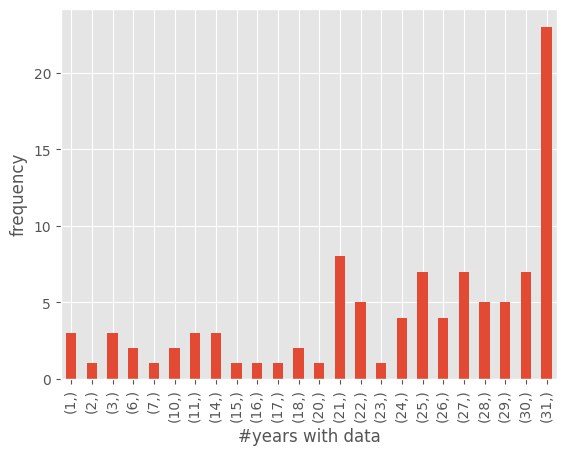

In [151]:
temp = tidy_df.groupby(['country', 'year']).count().reset_index()
temp = temp[['country','year']]
country_years = temp.groupby('country').count()
ax = country_years.value_counts(sort=False).plot.bar()
ax.set_xlabel('#years with data')
ax.set_ylabel('frequency')

plot above shows available data.  
31 is max (1985 to 2015)  
Whats a reasonable cutoff?  
10 years?

In [152]:
# get country names with less than k years of data available
temp = country_years.reset_index()
MIN_DATA_YEARS = 3
names = temp[temp.year <= MIN_DATA_YEARS].country.values
names

array(['Bosnia and Herzegovina', 'Cabo Verde', 'Dominica', 'Macau',
       'Oman', 'Saint Kitts and Nevis', 'San Marino'], dtype=object)

In [153]:
# remove countries determined above by using .isin with the prepended negation (~))
tidy_df = tidy_df[~tidy_df['country'].isin(names)]
tidy_df.shape

(27492, 10)

# Plot suidice per 100k rates for country, year etc
confused about per 100k colum: how to aggregate them to get per year value? mean? does not seem to fit visualizations on kaggle 
=> not possible. simply recalcualte by summing population and suicides_no in all categories and them take the mean over the years

In [154]:
def add_per100k(df):
    df['per100k'] = ((df.suicides_no / df.population) * 100_000)
    return df

country
Germany   14.4057216400
Name: per100k, dtype: float64


<AxesSubplot: ylabel='country'>

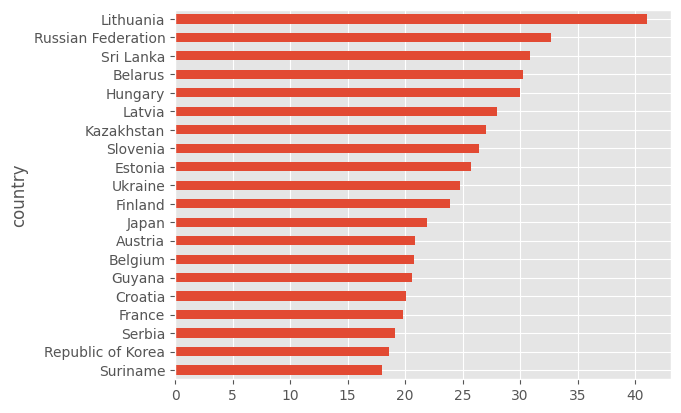

In [155]:
by_country_and_year = tidy_df.groupby(['country', 'year'])[
    ['population', 'suicides_no']].sum(numeric_only=True)
by_country_and_year['per100k'] = (
    by_country_and_year['suicides_no'] / by_country_and_year['population']) * 100_000
# by_country_and_year[['country','per100k']].mean('per100k')
country_alltime_avg = by_country_and_year.groupby('country').mean('per100k')
country_alltime_avg = country_alltime_avg.per100k
print(country_alltime_avg.filter(items=['Germany']))
country_alltime_avg = country_alltime_avg.sort_values()
country_alltime_avg[-20:].plot.barh()
# country_alltime_avg.plot.barh(x='per100k', y='country')
# country_alltime_avg.per100k.plot.barh()


In [156]:
# ger_2015 = tidy_df[tidy_df.year == 2015][tidy_df.country == 'Germany'][['population','suicides_no']].sum(numeric_only=True)
# ger_2015['per100k'] = ((ger_2015.suicides_no / ger_2015.population) * 100_000)
# ger_2015

In [157]:
avg_1995 = tidy_df[tidy_df.year == 1995][['population','suicides_no']].sum()
add_per100k(avg_1995)
avg_1995

population    1591559103.0000000000
suicides_no       243544.0000000000
per100k               15.3022278306
dtype: float64


# NOTE
reported values on kaggle are not averages over country per 100k but rather the facotr : sum all suicides/ sum all popluation

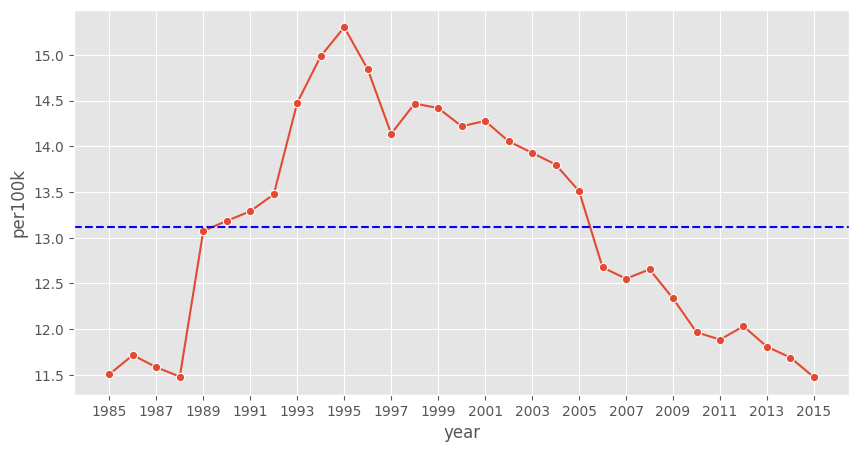

In [158]:
# plot avg per 100k rate across all coutnries per year in a line plot
tidy_df = utils.clean_data(pd.read_csv('suicide_ds_2016.csv'))

avg_per_year = tidy_df.groupby(['year'])[
    ['population', 'suicides_no']].sum(numeric_only=True)
add_per100k(avg_per_year)
# avg_per_year.mean('per100k', axis='column')
# global_mean = 
fig, ax = plt.subplots(figsize=(10,5)) #for size of figure

t = sns.lineplot(data=avg_per_year.per100k,markers=True, ax=ax, marker="o")
ticks = np.arange(1985,2016,2)
t.set_xticks(ticks, labels=ticks)
t.axhline(avg_per_year.per100k.mean(), linestyle='--', color='blue')



## groupt trend separated by gender

Text(0, 0.5, 'Suicides per 100k')

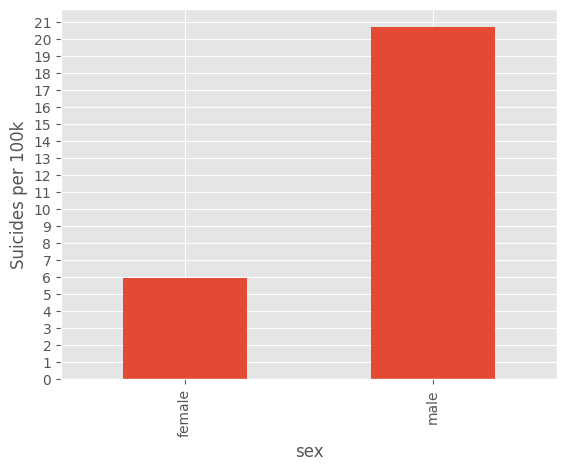

In [159]:
avg_by_sex = tidy_df.groupby('sex')[
    ['population', 'suicides_no']].sum(numeric_only=True)
add_per100k(avg_by_sex)
p = avg_by_sex.per100k.plot.bar()
p.set_yticks(np.arange(0,22,1))
p.set_ylabel('Suicides per 100k')

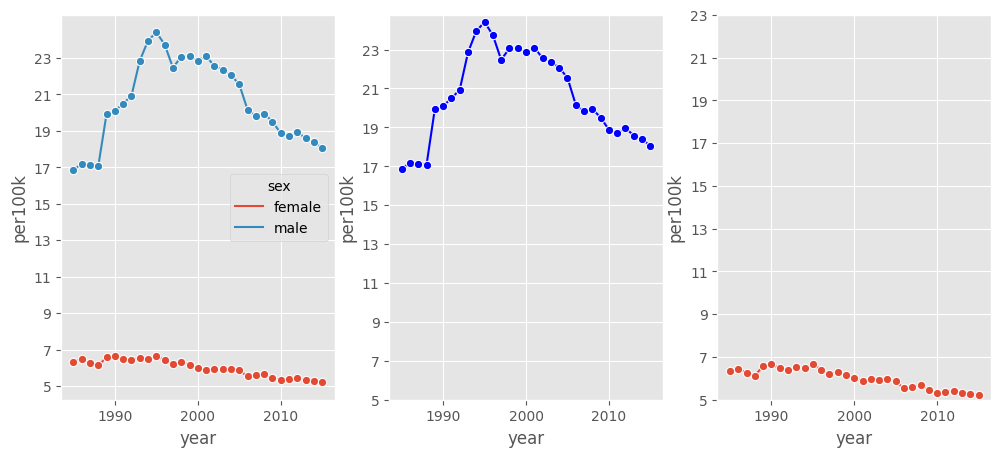

In [160]:
# same for trend over time
avg_by_sex_per_year = tidy_df.groupby(['sex','year'])[
    ['population', 'suicides_no']].sum(numeric_only=True)
add_per100k(avg_by_sex_per_year)
avg_by_sex_per_year= avg_by_sex_per_year.reset_index()
male = avg_by_sex_per_year[avg_by_sex_per_year.sex == 'male']
female= avg_by_sex_per_year[avg_by_sex_per_year.sex == 'female']
fig, ax = plt.subplots(1,3, figsize=(12,5))
yticks = np.arange(5,25,2)
t1 = sns.lineplot(data=avg_by_sex_per_year, x="year", y="per100k", ax=ax[0], hue="sex",markers=True,marker="o")
t1.set_yticks(yticks)
t2 = sns.lineplot(data=male, x="year", y="per100k", ax=ax[1],markers=True,marker="o", color='blue')
t2.set_yticks(yticks)
t3 = sns.lineplot(data=female, x="year", y="per100k", ax=ax[2],markers=True,marker="o")
t3.set_yticks(yticks)

## analyze country trends

<AxesSubplot: ylabel='country'>

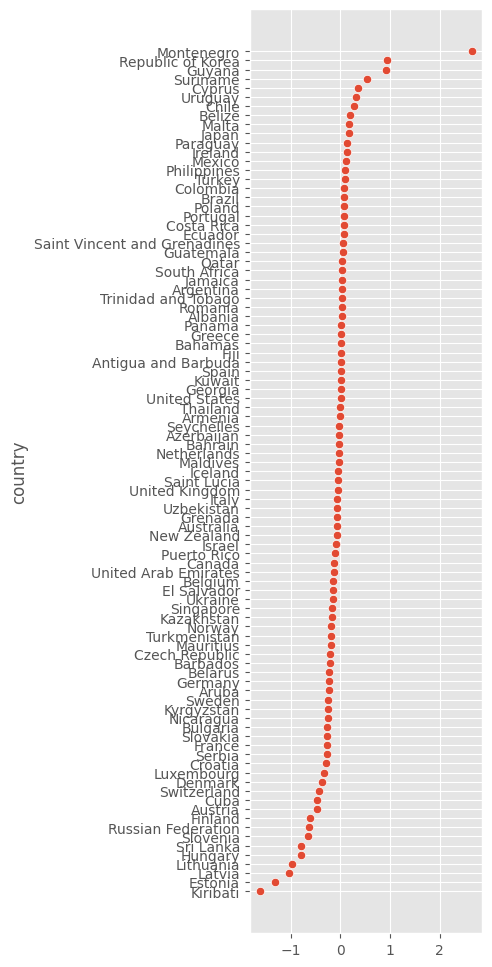

In [161]:
by_country_and_year = tidy_df.groupby(['country', 'year'])[
    ['population', 'suicides_no']].sum(numeric_only=True)
add_per100k(by_country_and_year)
by_country_and_year = by_country_and_year.reset_index()[
    ['country', 'year', 'per100k']]
by_country_and_year
# by_country_and_year= by_country_and_year[by_country_and_year.country == 'Germany']
# sns.relplot(data=by_country_and_year,x="year",y="per100k", col="country",kind="scatter", col_wrap=8)


def trendline(x, y, order=1):
    slope = np.polyfit(x, y, order)[-2]
    return float(slope)

def apply_trendline(df):
    return trendline(df.year.values, df.per100k.values)

trends = by_country_and_year.groupby('country').apply(apply_trendline).sort_values()[::-1]
# sns.scatterplot(trends_per_country, y='country')
fig, ax = plt.subplots(figsize=(3,12))
sns.scatterplot(x=trends.values, y=trends.keys(), ax=ax)


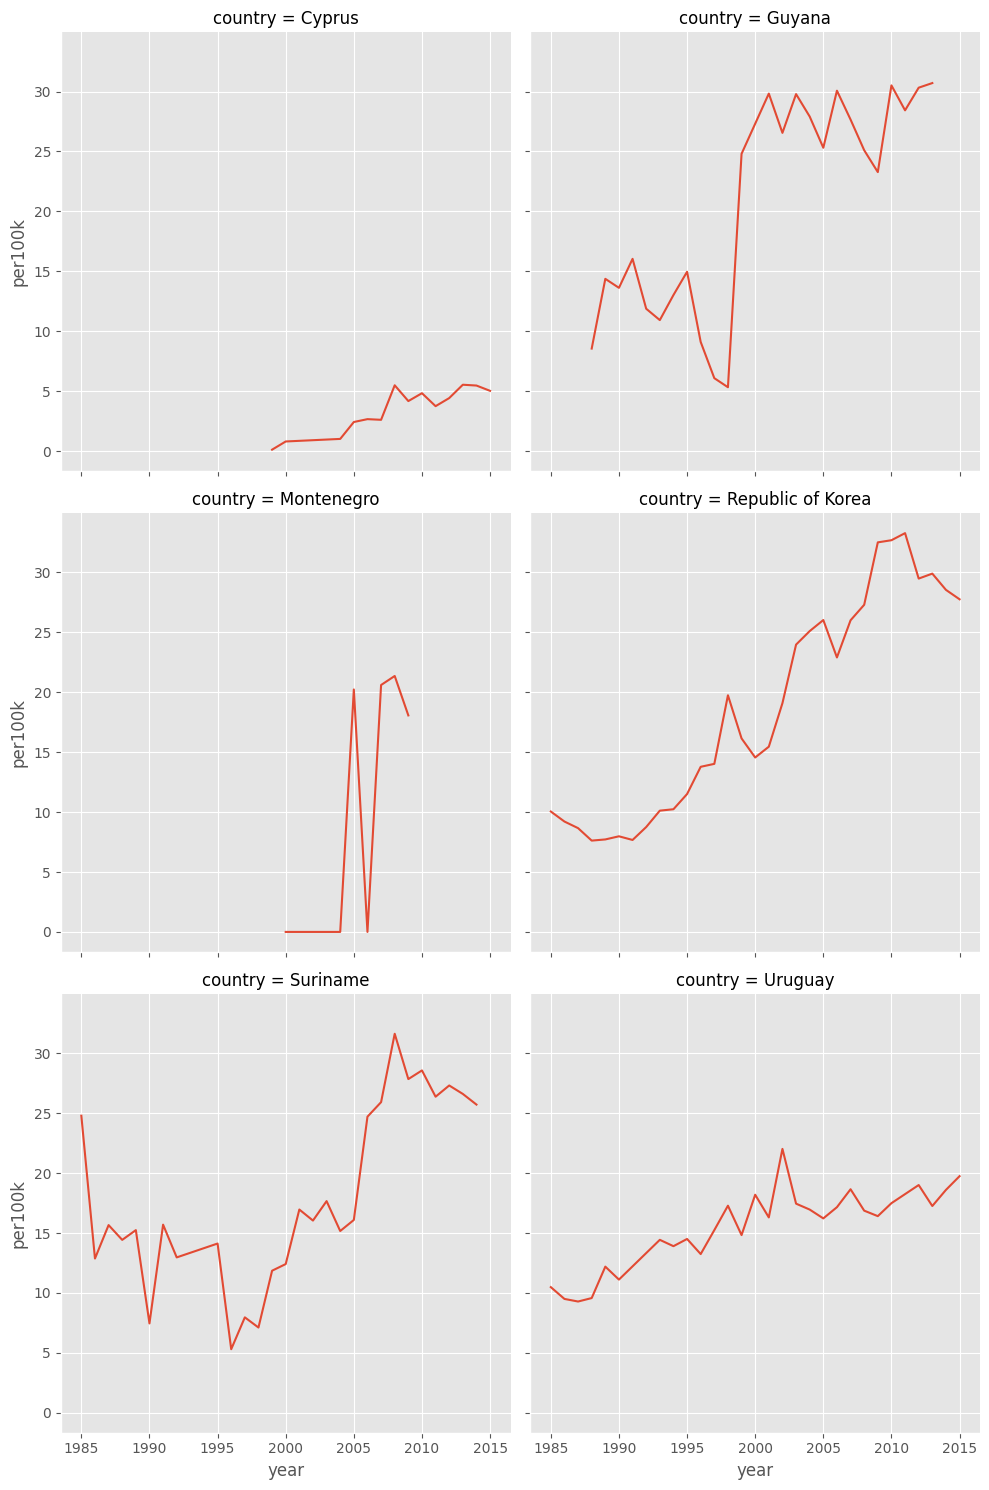

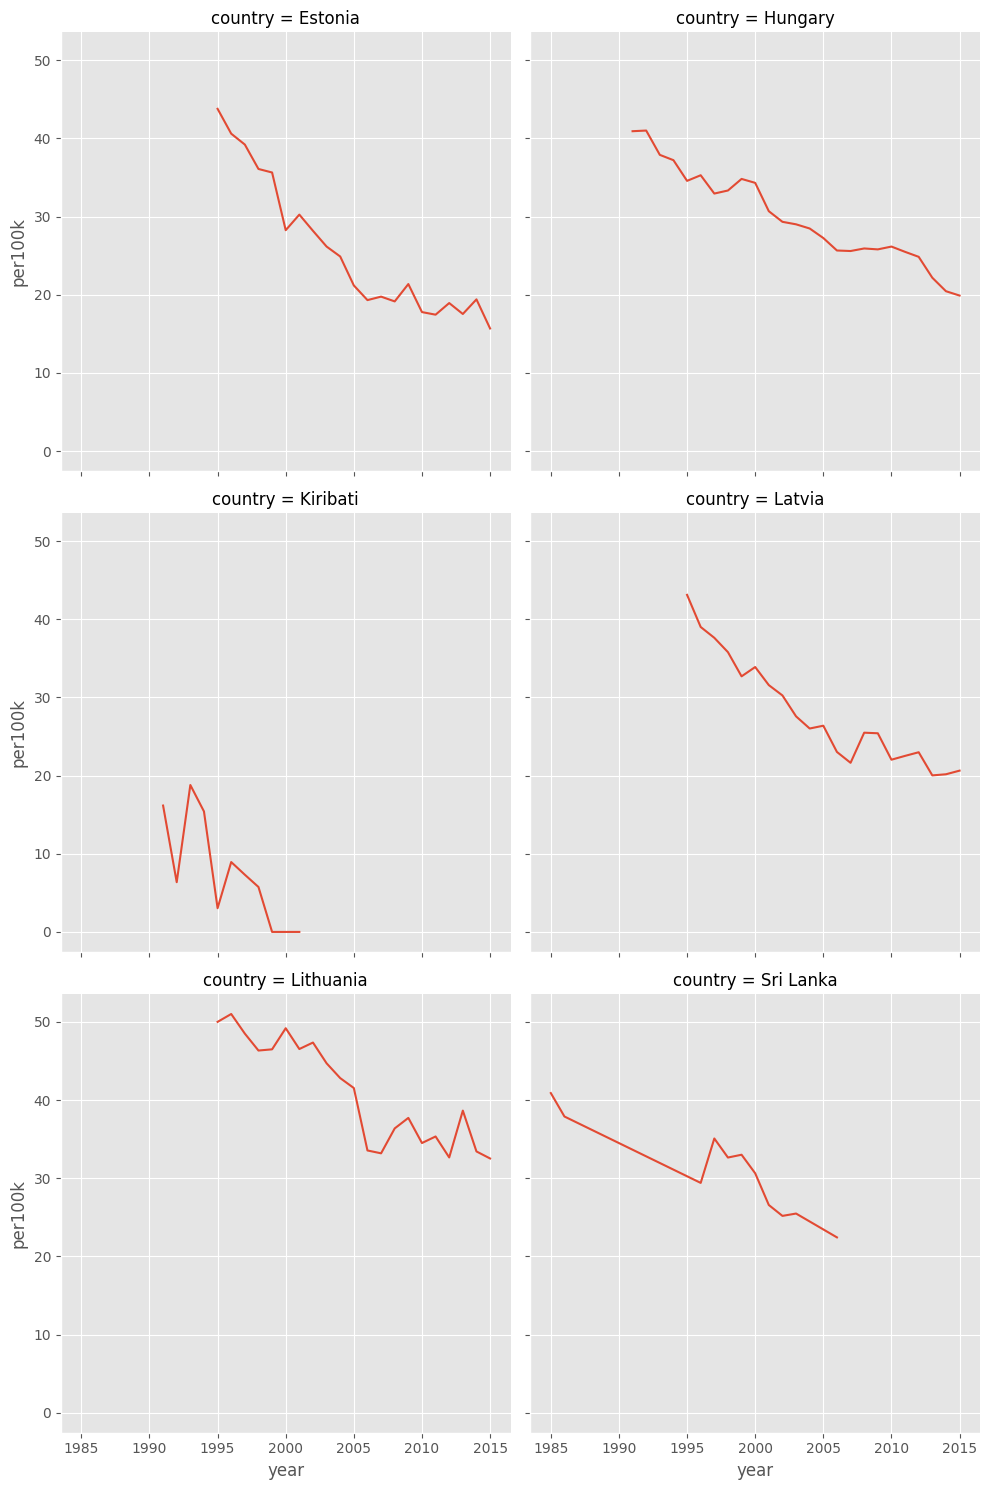

In [162]:
top_n_incr_trends = by_country_and_year[by_country_and_year.country.isin(trends[:6].keys())]
sns.relplot(data=top_n_incr_trends, x='year',y='per100k', col='country', col_wrap=2, kind='line')
top_n_decr_trends = by_country_and_year[by_country_and_year.country.isin(trends[-6:].keys())]
sns.relplot(data=top_n_decr_trends, x='year',y='per100k', col='country', col_wrap=2, kind='line')
